# Calibrazione 6
La calibrazione dell'8 non si può fare.
TODO: tutti i grafici

### Analisi spettro ADC singolo scintillatore

In [4]:
from lib import landau_mod
from lmfit.models import GaussianModel, ConstantModel
import sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1000
np.set_printoptions(threshold=sys.maxsize)

In [5]:
data = np.loadtxt("Calibrazione_6_e_8/scintillatore_6/ADC_S6_100000_1880V_51mV.dat", dtype=np.int64)
N = 100000

hist = np.apply_along_axis(np.bincount, axis=0, arr=data, minlength=N+1)
hist[:,0] = np.arange(N+1)
hist = hist[:1800, :10]
#print(hist)
chn = hist[:,0]
spectrum = hist[:,7]

plt.figure(figsize=(15, 5))
plt.plot(chn, spectrum)

mod = GaussianModel(prefix="a_") + GaussianModel(prefix="b_") + landau_mod
params = mod.make_params(a_amplitude=10000, a_center=156, a_sigma=30,
                         b_amplitude=10000, b_center=117, b_sigma=8,
                         mu=342, xi=dict(value=63, min=0.01), A=84000)
res = mod.fit(data=spectrum, params=params, x=chn, weights=None)
print(res.fit_report())
plt.plot(chn, res.best_fit, '-', label='best fit')
plt.plot(chn, res.init_fit, '--', label='init fit')
plt.show()



[[Model]]
    ((Model(gaussian, prefix='a_') + Model(gaussian, prefix='b_')) + Model(landau_func))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 126
    # data points      = 1800
    # variables        = 9
    chi-square         = 203026.342
    reduced chi-square = 113.359208
    Akaike info crit   = 8523.98832
    Bayesian info crit = 8573.44820
    R-squared          = 0.98472767
[[Variables]]
    a_amplitude:  11777.2470 +/- 263.773470 (2.24%) (init = 10000)
    a_center:     156.708748 +/- 0.74976767 (0.48%) (init = 156)
    a_sigma:      30.0090731 +/- 0.68495834 (2.28%) (init = 30)
    b_amplitude:  11168.1584 +/- 178.282924 (1.60%) (init = 10000)
    b_center:     117.741954 +/- 0.06473129 (0.05%) (init = 117)
    b_sigma:      8.42351826 +/- 0.09185013 (1.09%) (init = 8)
    mu:           342.822092 +/- 0.49618038 (0.14%) (init = 342)
    xi:           63.5054286 +/- 0.37616412 (0.59%) (init = 63)
    A:            84774.0691 +/- 371.902191 (0.44

### Analisi spettri ADC di tutti gli scintillatori

In [15]:
# Tutto usando gli scint 1-9, calcolando il piedestallo di quello su cui non triggero e sottraendolo al mpv
# landau di quello su cui ho triggerato
import lmfit
import uncertainties as u
from pprint import pprint

def hist_from_ADC(filename: str, index: int) -> np.ndarray:
    data = np.loadtxt(f"{filename}", dtype=np.int64)

    hist = np.apply_along_axis(np.bincount, axis=0, arr=data, minlength=np.max(data[1:,:])+1)
    hist[:,0] = np.arange(len(hist[:,0]))
    hist = hist[2:1800, :]
    return hist

ggl = GaussianModel(prefix="a_") + GaussianModel(prefix="b_") + landau_mod
gg = GaussianModel(prefix="a_") + GaussianModel(prefix="b_")
g = GaussianModel(prefix="a_")

In [26]:
import pandas as pd
from collections import defaultdict

spettri=dict({
    1: "Singole/ADC_S1_45000_2090V_70mV.dat",
    2: None,
    3: None,
    4: None,
    5: None,
    6: "Singole/ADC_S6_100000_1880V_51mV.dat",
    7: "Singole/ADC_S7_45000_2090V_70mV.dat",
    8: "Singole/ADC_S7_45000_2090V_70mV.dat",
    9: "Singole/ADC_S7_45000_2090V_70mV.dat"})

out = defaultdict(dict)
open("out.txt", 'w').close() # clears file from previous output

for trigger_index, filename in spettri.items():
    try:
        hist = hist_from_ADC(filename=filename, index=trigger_index)
    except FileNotFoundError:
        continue

    for i in spettri:
        chn = hist[:,0]
        spectrum = hist[:, i+1]

        mod = ggl if i==trigger_index else g
        params = mod.make_params(a_amplitude=10000, a_center=156, a_sigma=30,
                                b_amplitude=10000, b_center=117, b_sigma=8,
                                mu=342, xi=dict(value=63, min=0.01), A=84000)
        res = mod.fit(data=spectrum, params=params, x=chn, weights=None)

        if res.redchi > 300 and (mod != ggl):
            print(f"{trigger_index}{i} has big chisq (>300) for model {mod}, trying again with next")
            mod = gg
            params = mod.make_params(a_amplitude=10000, a_center=20, a_sigma=30,
                                b_amplitude=10000, b_center=60, b_sigma=8,
                                mu=342, xi=dict(value=63, min=0.01), A=84000)
            res = mod.fit(data=spectrum, params=params, x=chn, weights=None)


        if res.redchi > 300 and (mod != ggl):
            print(f"{trigger_index}{i} has big chisq (>300) for model {mod}, trying again with next")
            mod = ggl
            params = mod.make_params(a_amplitude=10000, a_center=20, a_sigma=30,
                                b_amplitude=10000, b_center=60, b_sigma=8,
                                mu=342, xi=dict(value=63, min=0.01), A=84000)
            res = mod.fit(data=spectrum, params=params, x=chn, weights=None)
            if res.redchi > 300:
                print(f"WARNING: {trigger_index}{i} failed with all models available")
        
        with open('out.txt', 'a+') as f: #writes new output
            print(f"{trigger_index} ------------ {i} \n ==================================== \n {res.fit_report()}) \n ==================================== \n", file=f)
           

        plt.figure(figsize=(15, 5))
        plt.plot(chn, spectrum)
        plt.plot(chn, res.best_fit, '-', label='best fit')
        plt.savefig(f"Singole/Immagini/{trigger_index}{i}.png", dpi=300)
        plt.close() #prevents showing in output

        out[trigger_index][i] = res
        #return res #return res.params, res.uvars


print(out)

62 has big chisq (>300) for model Model(gaussian, prefix='a_'), trying again with next
67 has big chisq (>300) for model Model(gaussian, prefix='a_'), trying again with next
67 has big chisq (>300) for model (Model(gaussian, prefix='a_') + Model(gaussian, prefix='b_')), trying again with next
68 has big chisq (>300) for model Model(gaussian, prefix='a_'), trying again with next
defaultdict(<class 'dict'>, {6: {1: <lmfit.model.ModelResult object at 0x0000021B15C60A70>, 2: <lmfit.model.ModelResult object at 0x0000021B0E227200>, 3: <lmfit.model.ModelResult object at 0x0000021B5F59CEC0>, 4: <lmfit.model.ModelResult object at 0x0000021B0E649E20>, 5: <lmfit.model.ModelResult object at 0x0000021B0FEB46E0>, 6: <lmfit.model.ModelResult object at 0x0000021B0FD4A060>, 7: <lmfit.model.ModelResult object at 0x0000021B22819940>, 8: <lmfit.model.ModelResult object at 0x0000021B0FE64C80>, 9: <lmfit.model.ModelResult object at 0x0000021B0E670680>}})


In [33]:
a = out[6][2].uvars["a_center"]
b = out[6][2].uvars["b_center"]
print(a, b, np.mean(np.array([a, b])))

36.72+/-0.10 25.51+/-0.19 31.11+/-0.14


In [44]:
for trigger_index in spettri:
    try: # checks if spectra exist. Keeps working only if it finds spectrum
        hist = hist_from_ADC(filename=spettri[trigger_index], index=trigger_index)
    except FileNotFoundError:
        continue

    centers = []
    for i in spettri:
        print(trigger_index, i)
        if i != trigger_index:
            try:
                a, b = out[trigger_index][i].uvars["a_center"], out[trigger_index][i].uvars["b_center"]
                a_amp, b_amp = out[trigger_index][i].uvars["a_amplitude"], out[trigger_index][i].uvars["b_amplitude"]
                center = (a*a_amp + b*b_amp)/(a_amp + b_amp)
            except KeyError:
                a = out[trigger_index][i].uvars["a_center"]
                center = a
            centers.append(center)
        else:
            mpv_landau = out[trigger_index][i].uvars["mu"]
    
    with open('out.txt', 'w+') as f: # writes values to file
        print(f"ADC channel (value - background) of {trigger_index} is: ", mpv_landau - np.mean(centers), file=f)
    
        









#print(out[6][1].uvars["a_amplitude"])
#print(hist_from_ADC("Singole/ADC_S6_100000_1880V_51mV.dat", 6))

6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
313.6+/-0.5 6


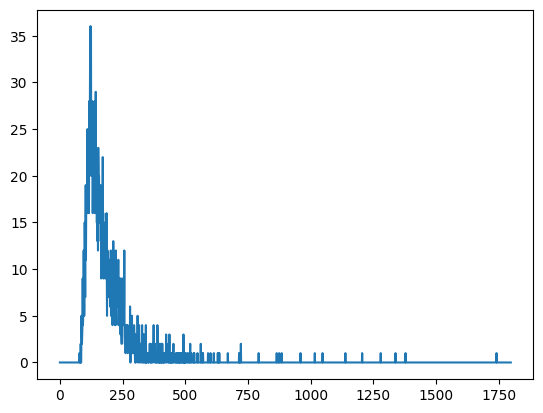

In [ ]:
import lmfit
import uncertainties as u
from pprint import pprint

def hist_from_ADC(filename: str, index: int) -> np.ndarray:
    data = np.loadtxt(f"{filename}", dtype=np.int64)

    hist = np.apply_along_axis(np.bincount, axis=0, arr=data, minlength=np.max(data[1:,:])+1)
    hist[:,0] = np.arange(len(hist[:,0]))
    hist = hist[:1800, :]
    return hist

hist = hist_from_ADC("Doppie_col_Piccolino/ADC_D91_2500.dat", 4)
plt.plot(hist[:,0], hist[:,2])


def analisi_trigger(filename: str, index: int, visualize: bool=True, verbose: bool=True):
    hist = hist_from_ADC(filename=filename, index=index)

    chn = hist[:,0]
    spectrum = hist[:, index]

    mod = GaussianModel(prefix="a_") + GaussianModel(prefix="b_") + landau_mod
    params = mod.make_params(a_amplitude=10000, a_center=156, a_sigma=30,
                            b_amplitude=10000, b_center=117, b_sigma=8,
                            mu=342, xi=dict(value=63, min=0.01), A=84000)
    res = mod.fit(data=spectrum, params=params, x=chn, weights=None)

    if verbose:
        print(f"{filename} ------------ {index} \n ==================================== \n {res.fit_report()}) \n ==================================== \n")

    if visualize:
        plt.figure(figsize=(15, 5))
        plt.plot(chn, spectrum)
        plt.plot(chn, res.best_fit, '-', label='best fit')
    return res #return res.params, res.uvars

def analisi_non_trigger(filename: str, index: int,visualize: bool=True, verbose: bool=False):
    hist = hist_from_ADC(filename=filename, index=index)
    
    chn = hist[:,0]
    spectrum = hist[:, index]

    mod = GaussianModel(prefix="a_")
    params = mod.make_params(a_amplitude=10000, a_center=156, a_sigma=30)
    res = mod.fit(data=spectrum, params=params, x=chn, weights=None)

    if verbose:
        print(f"{filename} ------------ {index} \n ==================================== \n {res.fit_report()}) \n ==================================== \n")

    if visualize:
        plt.figure(figsize=(15, 5))
        plt.title(f"{index}")
        plt.plot(chn, spectrum)
        plt.plot(chn, res.best_fit, '-', label='best fit')
    return res #return res.params, res.uvars 
    
"""
plt.show()  
pp = analisi_trigger("Calibrazione_6_e_8/scintillatore_6/ADC_S6_100000_1880V_51mV.dat", index=6).uvars
print(u.covariance_matrix(list(pp.values())))
"""

# Calibrazione scale dei tempi rispetto al piccolino

[[   1  147 3686 3663 3642 3578 3619 3619 3587   41 4069 4068 4068 4068
  4068 4068 4068]
 [   2  140 3688 3663 3642 3578 3621 3620 3588   41 4069 4069 4069 4069
  4069 4069 4069]
 [   3  155 3688 3664 3643 3579 3622 3621 3589   41 4071 4070 4070 4070
  4070 4070 4070]
 [   4  142 3688 3664 3643 3579 3622 3620 3589   41 4069 4068 4068 4068
  4068 4068 4068]
 [   5  150 3690 3665 3644 3580 3622 3621 3589   41 4070 4070 4070 4070
  4070 4070 4070]
 [   6  146 3689 3664 3643 3579 3621 3620 3589   41 4069 4069 4069 4069
  4069 4069 4069]
 [   7  160 3688 3664 3643 3578 3621 3620 3588   41 4071 4070 4070 4070
  4070 4070 4070]
 [   8  140 3689 3664 3644 3579 3621 3620 3588   41 4069 4069 4069 4069
  4069 4069 4069]
 [   9  161 3688 3663 3643 3578 3621 3619 3588   41 4069 4069 4069 4069
  4069 4069 4069]
 [  10  154 3689 3664 3644 3579 3621 3621 3589   41 4069 4069 4069 4069
  4069 4069 4069]
 [  11  160 3689 3664 3643 3579 3622 3621 3589   41 4069 4069 4069 4069
  4069 4069 4069]
 [  12  14

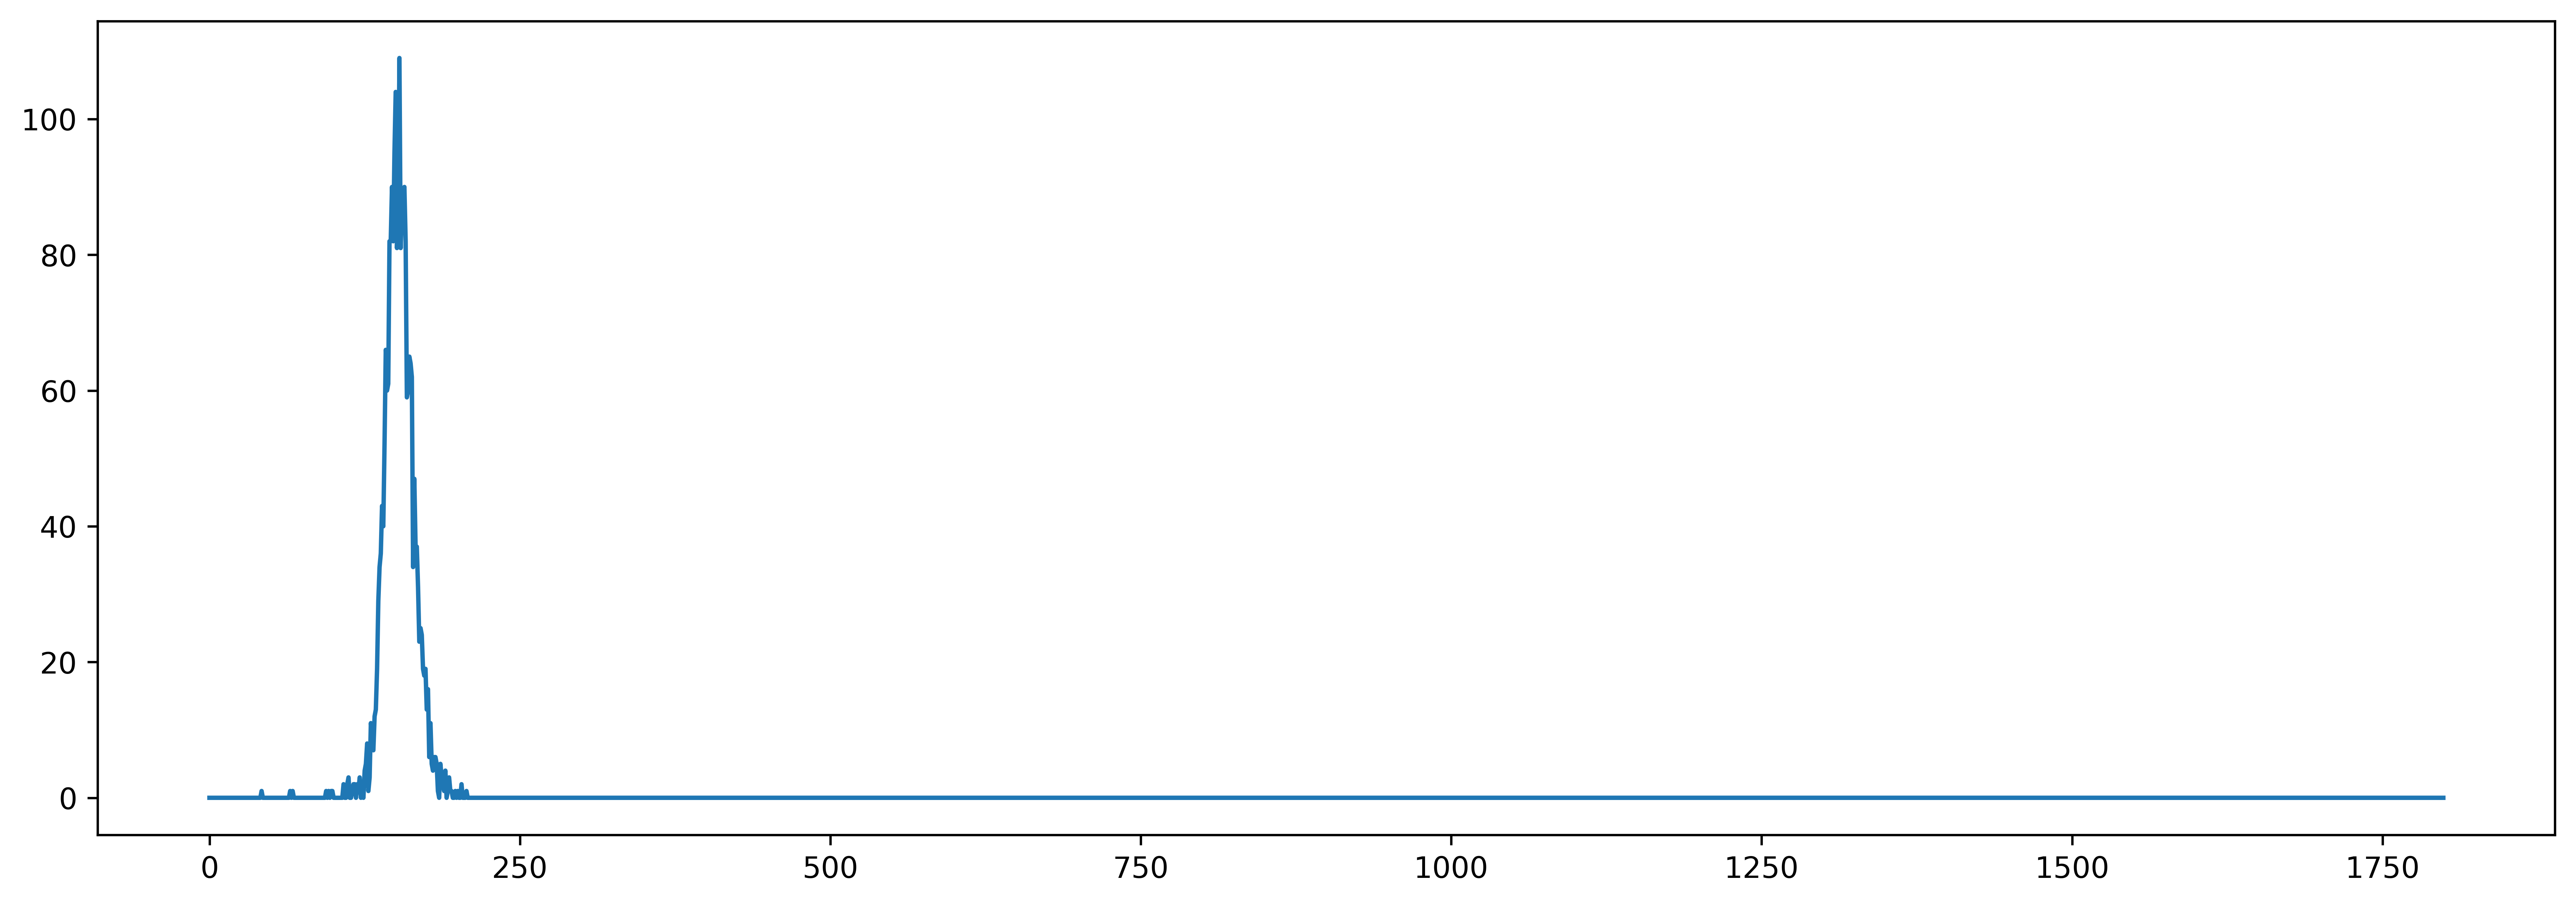

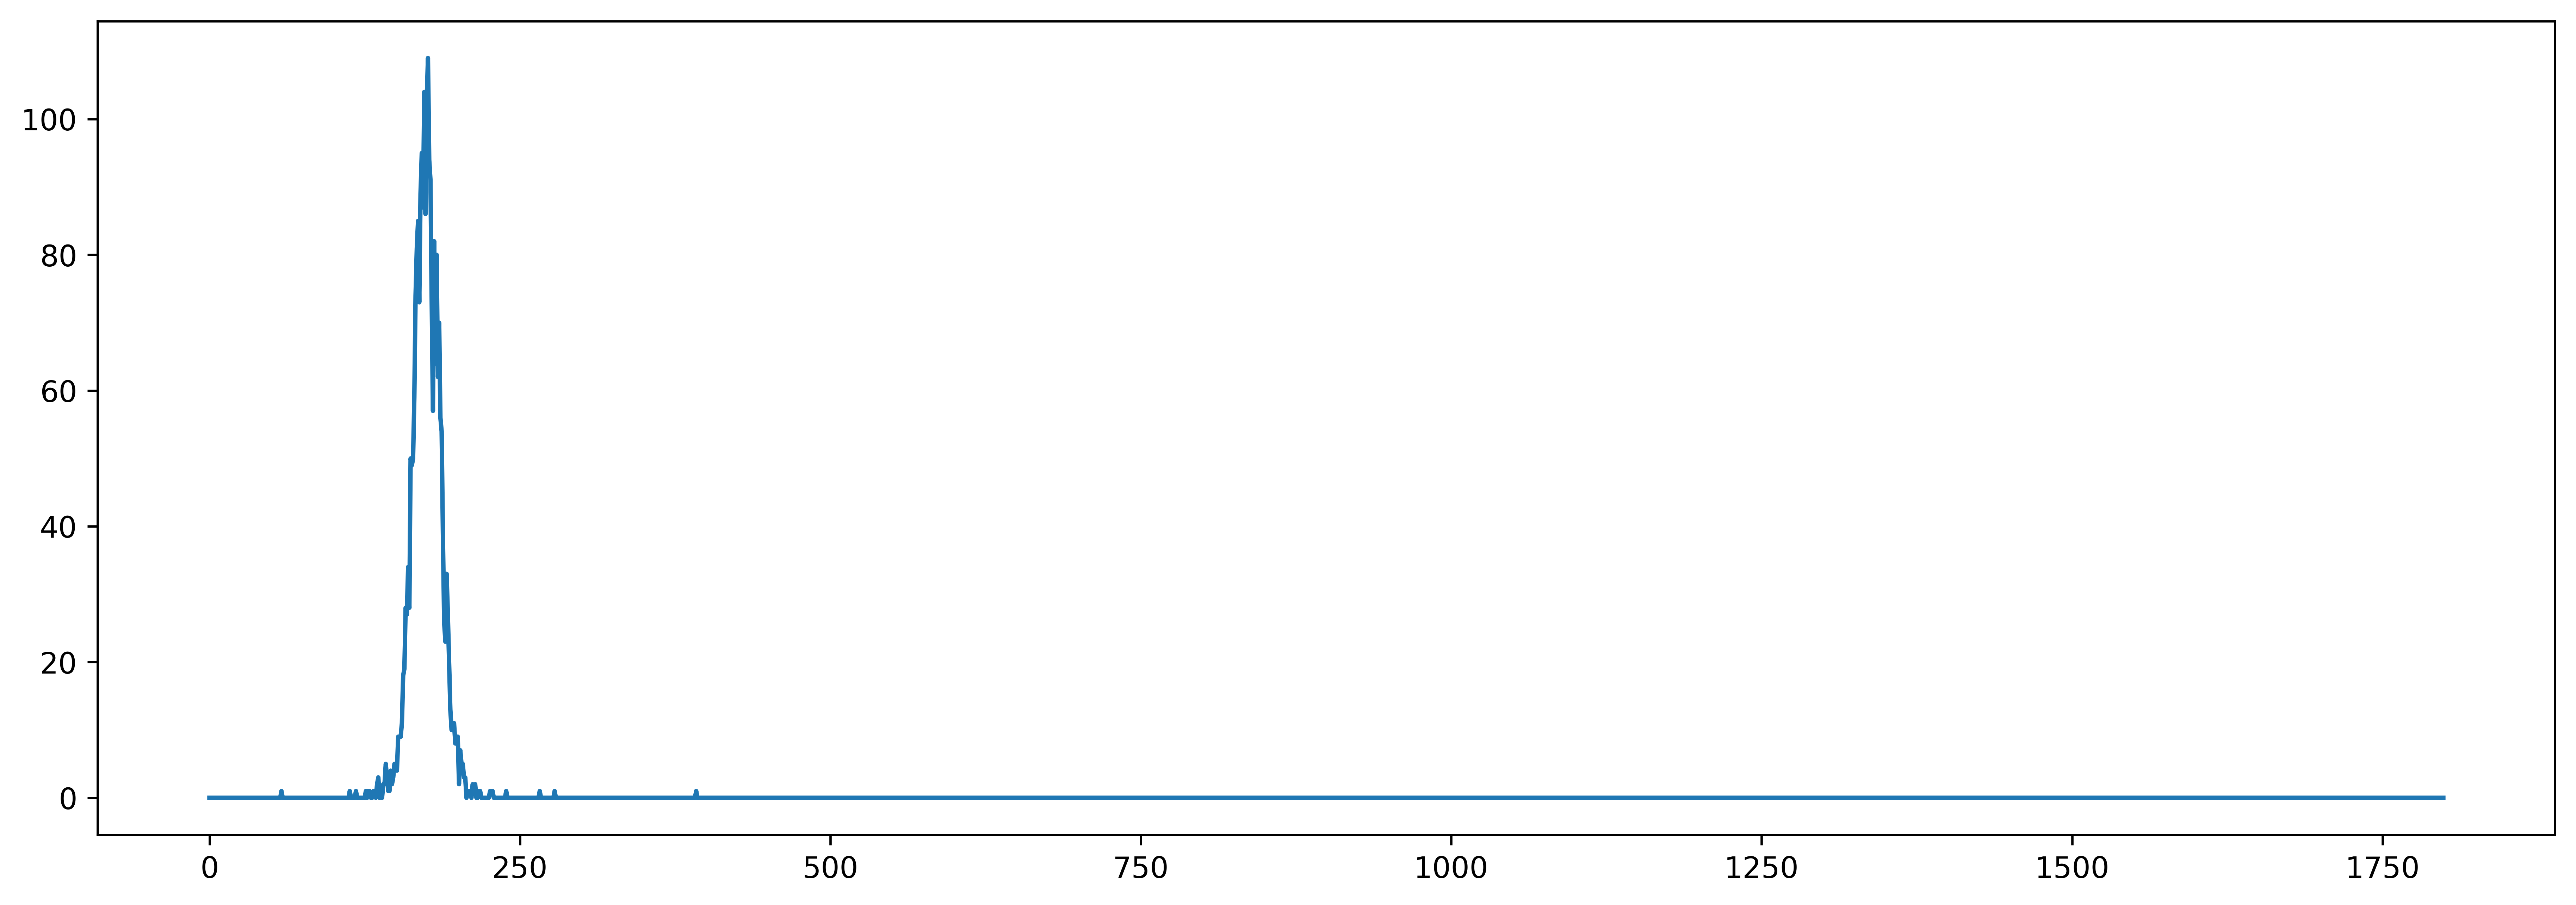

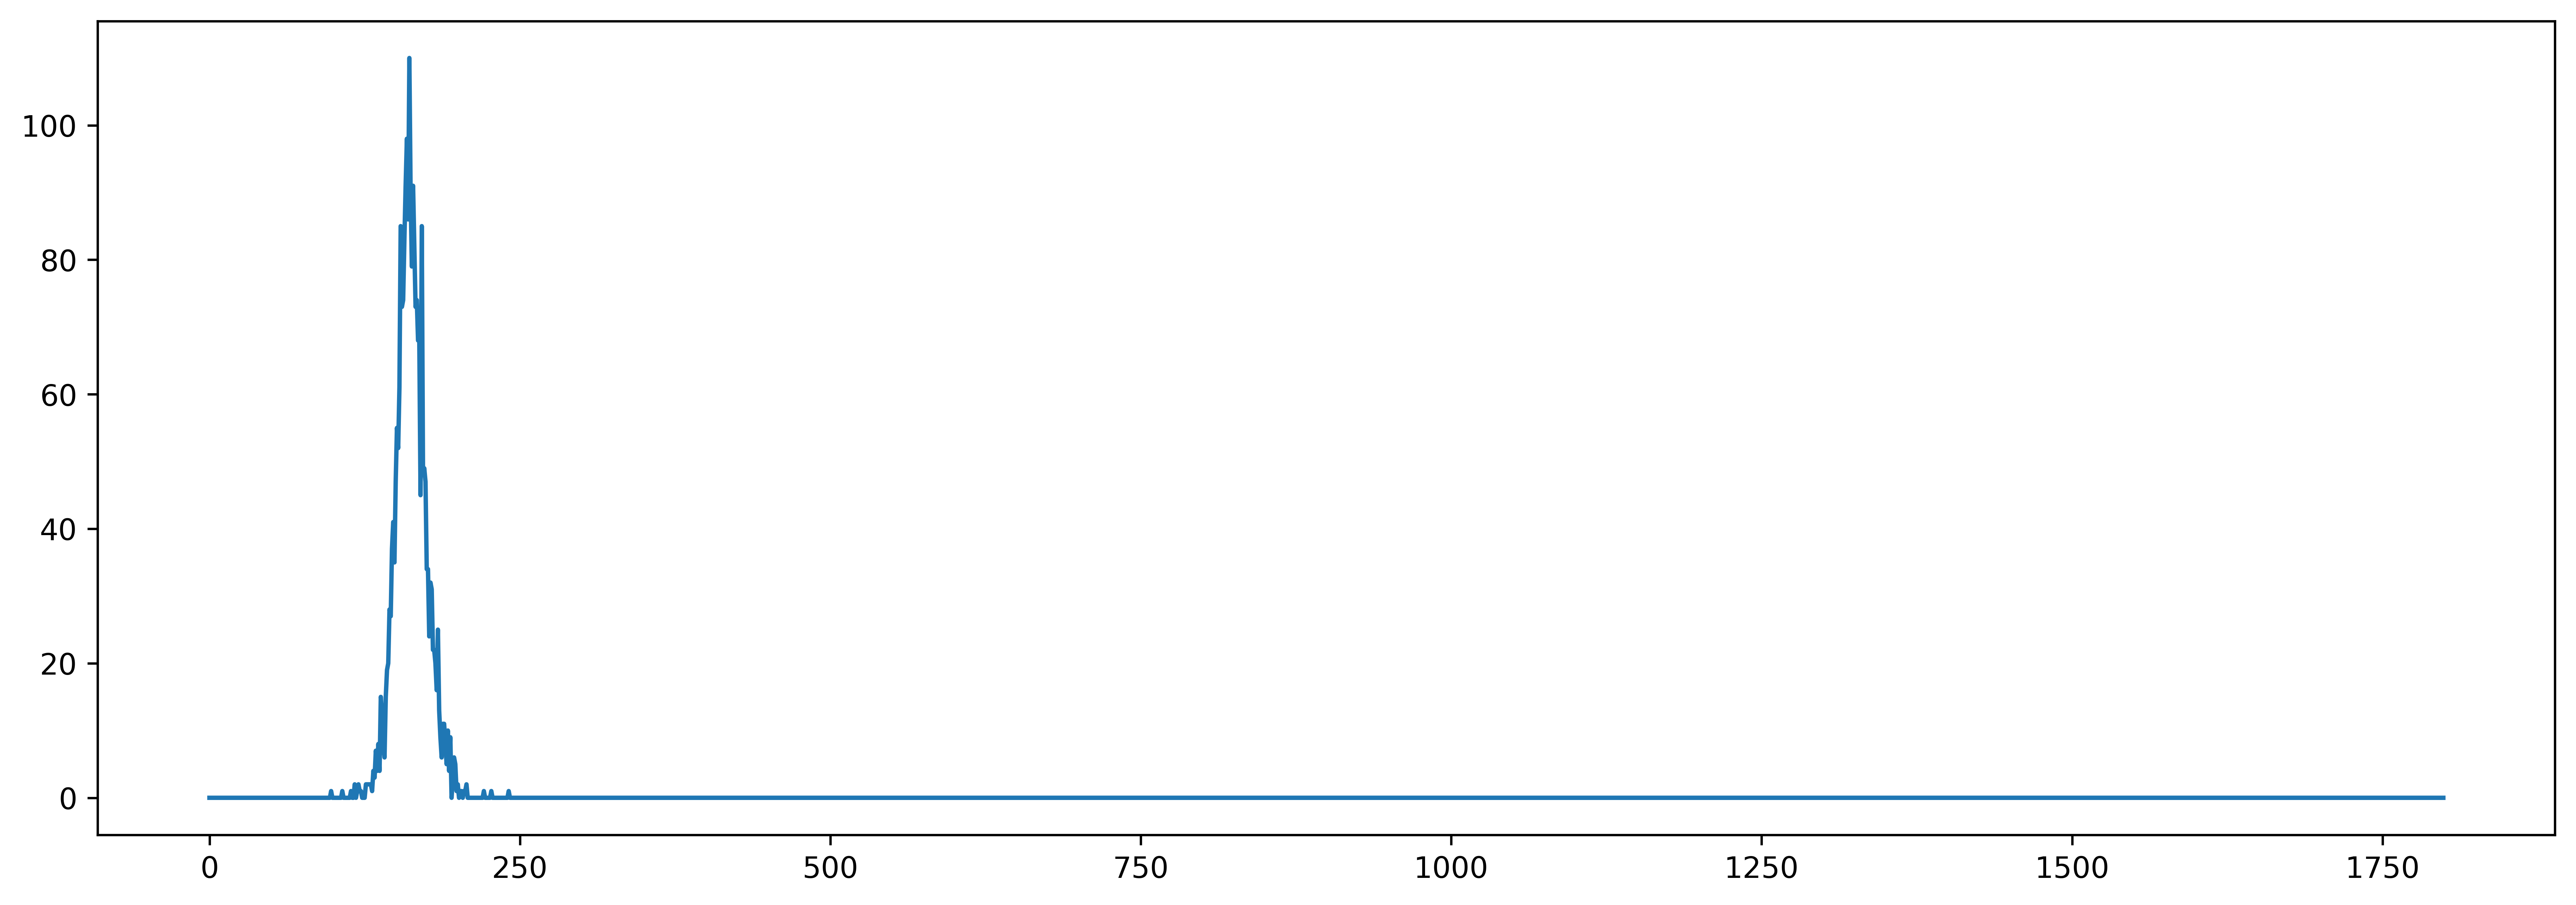

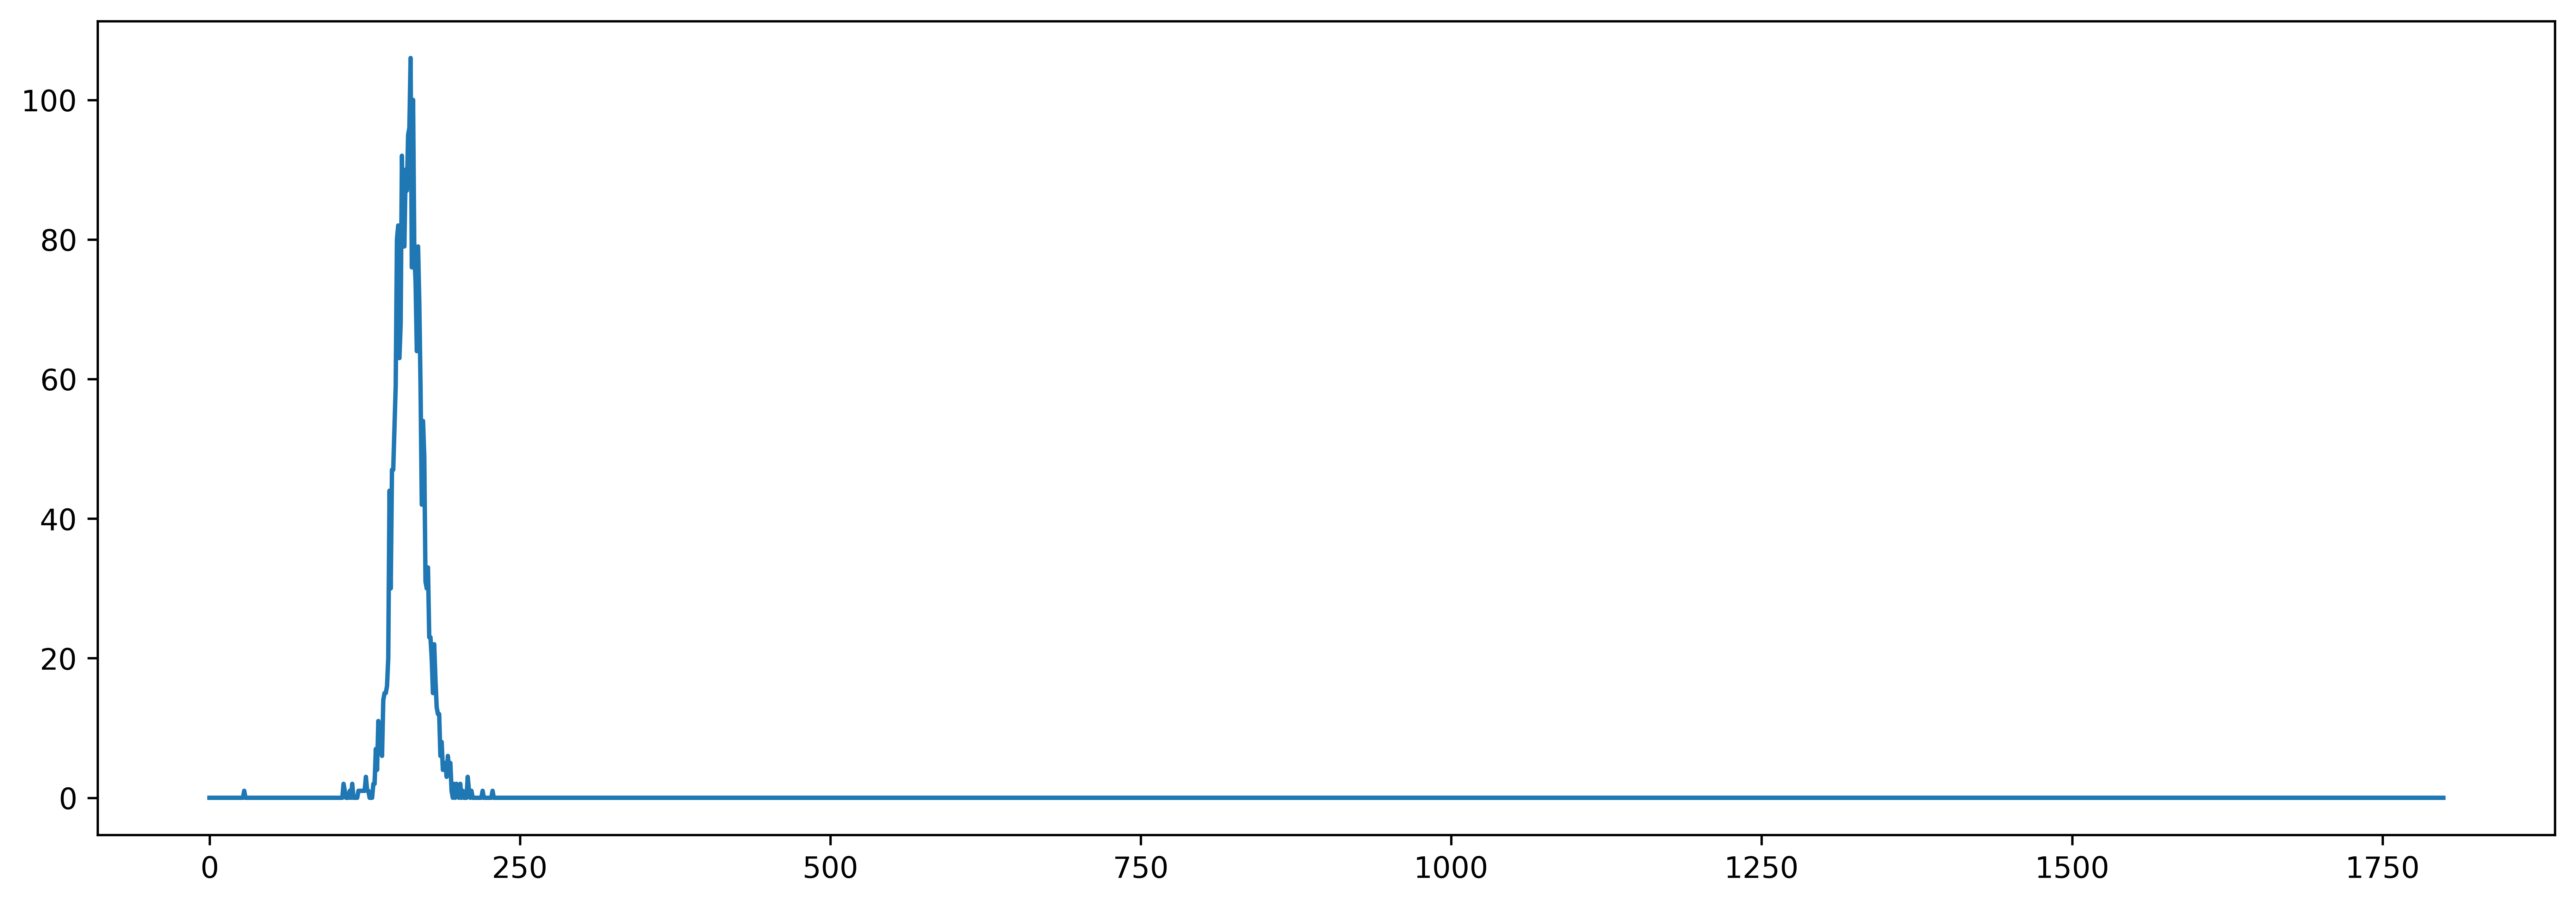

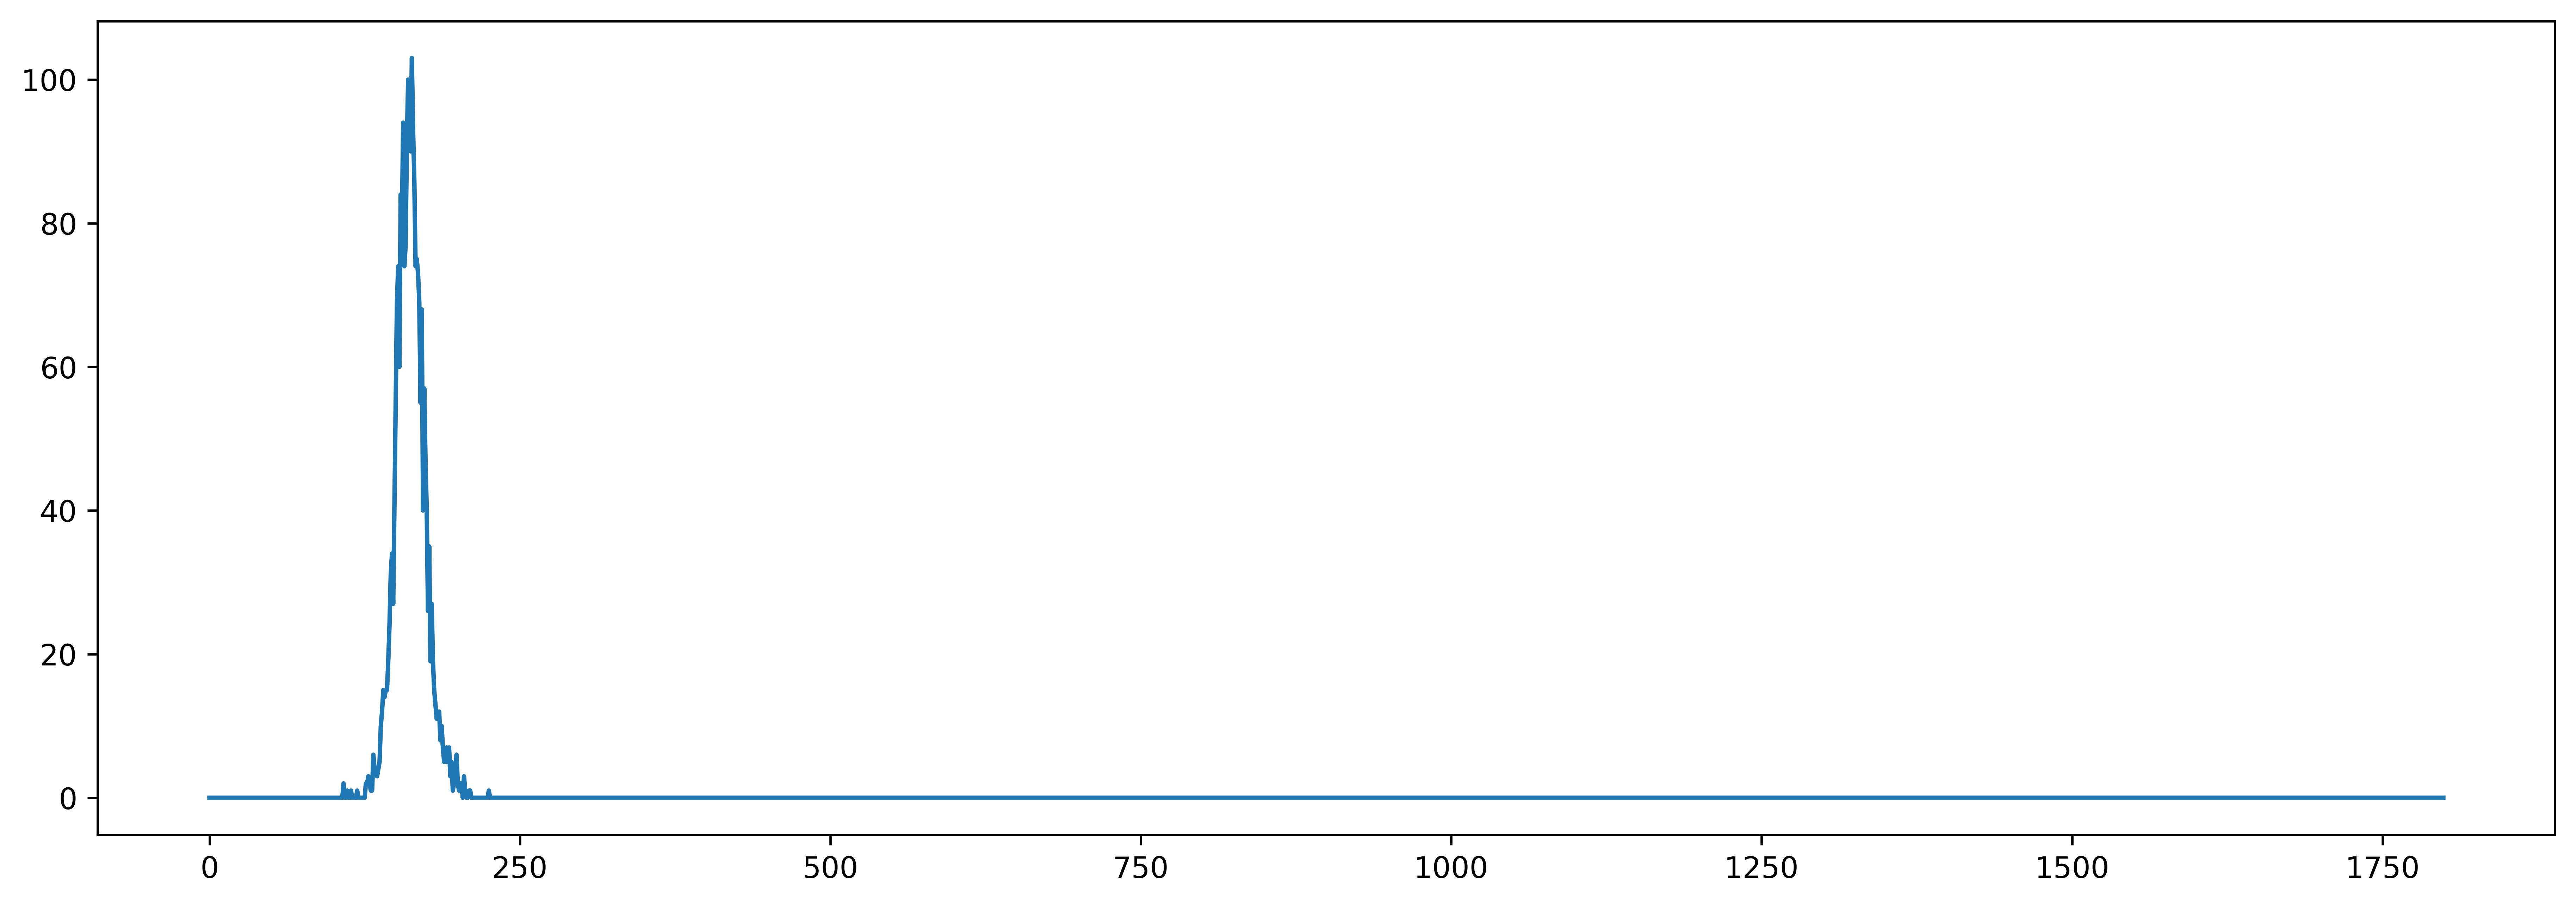

In [ ]:
from lib import landau_mod
from lmfit.models import GaussianModel, ConstantModel
import sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
np.set_printoptions(threshold=sys.maxsize)

N=2500
for i, filename in enumerate(["91", "92", "93", "94", "95"]):
    data = np.loadtxt(f"Doppie_col_Piccolino/Copia_dati_TDC_per_analisi/{filename}.dat", dtype=np.int64)
    data = np.delete(data, 1, axis=1)
    print(data)
    hist = np.apply_along_axis(np.bincount, axis=0, arr=data, minlength=np.max(data)+1)
    hist[:,0] = np.arange(len(hist[:,0]))
    hist = hist[:1800, :10]
    #print(hist)
    chn = hist[:,0]
    spectrum = hist[:,i+1]
    plt.figure(figsize=(15,5))
    plt.plot(chn,spectrum, label=f"{i}")
